# Adjust Image Colors

Images of museum specimens where taken various lighting conditions without any kind of color calibration guide (a color checker card). This is how I to try to calibrate the colors. The only constant in all of the images are the envelopes that store the physical samples and have the QR-code on them. We made sure to place the envelopes in the pictures of the specimens so we could always link them. The color of the envelopes are kind of consistent, or at least more consistent than the other parts of the photos.

The algorithm: **It's wrong in so many ways but I'm working with what I have.**
1. [Get exemplar](#The-Exemplar): Find an image with a reasonable quality. It has a "good" color and is not too bright or too dark we will use that as the "exemplar" for matching with the the other images colors.
1. [Get QR-code bounding box](#QR-Code-Bounding-Box):
    1. find the QR-code corners and make a bounding box of the QR-code. Max and min X & Y coordinates.
    2. Pad the bounding box to pick up more of the envelope without spilling into the rest of the herbarium sheet.
1. [Get the average RGB values](#Average-RGB-Values): Get the average of each color (RGB ) of the bounding box.
1. [Get average distance](#Distance): Calculate how far off the average RGB values are from the exemplar averages.
1. [Adjust image](#Adjust-Image): Adjust the RGB values for the entire image by average difference.
1. [Display images](#Display-Images): Because there are numerous ways this adjustment can fail I save both the original image (with a bounding box around the QR-code) and the adjusted image in two-up fashion, original on the right and adjusted on the left.

## Basic Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
from pathlib import Path

# import cv2
import matplotlib
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
import zbar  # zbarlight does not get the position of the QR-Code

from tqdm import tqdm
from ipywidgets import interact
from PIL import Image

import nitfix.lib.image_util as i_util
import nitfix.lib.util as util

In [3]:
%load_ext autoreload
%autoreload 2

There are two datasets I'm working with here. The first set contains the exemplar image  so we get the exemplar image first and, if needed, adjust the paths for the second dataset.

In [4]:
ROOT = Path('..') / util.SAMPLE_DATA

IN_DIR = ROOT / 'nitfix_sample_2400_2020-04-07a'
OUT_DIR = ROOT / 'nitfix_sample_2400_2020-04-07b'

# This is the image we use for calibrating the other images
EXEMPLAR = IN_DIR / 'Tingshuang_TEX_nitfix_photos_L1040918.JPG'
EXEMPLAR = str(EXEMPLAR)

# IN_DIR = DATA_DIR / 'nitfix_sample_100_2020-04-09a'
# OUT_DIR = DATA_DIR / 'nitfix_sample_100_2020-04-09b'

IN_PATHS = list(IN_DIR.glob('*.[Jj][Pp][Gg]'))

## The Exemplar

This was determined by visually scanning of the images.

Notice the blue box around the QR-code on the envelope. The area between the blue and the cyan boxes is what is actually being used as the "exemplar".

![The exemplar](images/adjust_image_color_exemplar.png?nounce=2)

In [5]:
def get_exemplar_index():
    for i, path in enumerate(IN_PATHS):
        path = str(path)
        if path == EXEMPLAR:
            print(i, path)
            return i


EXEMPLAR_IDX = get_exemplar_index()
EXEMPLAR_IDX

1199 ../data/raw/sampled_images/nitfix_sample_2400_2020-04-07a/Tingshuang_TEX_nitfix_photos_L1040918.JPG


1199

## QR-Code Bounding Box

This value expands the bounding box but keeps the entire rectangle inside of the envelope.

In [6]:
PAD = 75  # Pad the QR-Code bounding box by this many pixels

Create a bigger box surrounding the inner one.

In [7]:
def expand_bbox(bbox):
    return (
        min(bbox[0], bbox[2]) - PAD,
        min(bbox[1], bbox[3]) - PAD,
        max(bbox[0], bbox[2]) + PAD,
        max(bbox[1], bbox[3]) + PAD)

A helper function for drawing boxes on images.

In [8]:
def draw_rectangle(ax, bbox, color):
    wide = abs(bbox[2] - bbox[0])
    high = abs(bbox[3] - bbox[1])
    rect = patches.Rectangle(
        bbox[:2],
        wide, high,
        fill=False,
        edgecolor=color,
        lw=2)
    patch = ax.add_patch(rect)

Get the image from the path index.

In [9]:
def get_image(idx):
    path = str(IN_PATHS[idx])
    return Image.open(path)

Get the inner and outer rectangles around the QR-code.

In [10]:
def get_image_rectangles(image):
    inner = i_util.locate_qr_code(image)
    if not inner:
        print('Could not find the QR-code.')
        return None, None
    outer = expand_bbox(inner)
    return inner, outer

A function for displaying the boxes.

In [11]:
def draw_boxes(idx, figsize):
    image = get_image(idx)

    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.axis('off')

    inner, outer = get_image_rectangles(image)
    if inner:
        outer = expand_bbox(inner)
        draw_rectangle(ax, outer, 'blue')
        draw_rectangle(ax, inner, 'cyan')

    ax.imshow(image)

    plt.show()

What we're interested in is the envelope color. I have removed the QR-code itself but the printed UUID is still within the two boxes and may influence the color adjustment.

Notice the odd coloration of some of the images. Some of this is due to the faded nature of the specimen and some of it is due to the conditions at the time of the photograph.

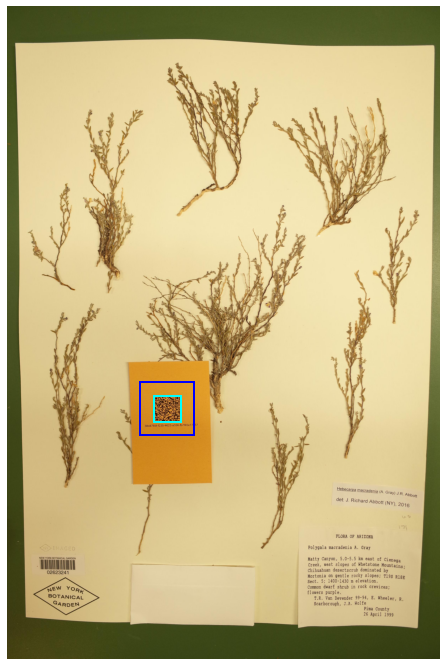

In [12]:
# interact(
#     draw_boxes,
#     idx=(0, len(IN_PATHS) - 1),
#     figsize=([10, 12, 15, 20, 25]))
draw_boxes(559, 12)

## Average RGB Values

Now calculate the average colors (RGB) of the area between the two rectangles. There are all sorts of games we could do here but we're going to leave it at this simple calculation for now.

In [13]:
def get_average_colors(image, inner, outer):
    data = np.asarray(image, dtype='int64')

    crop = data[inner[1]:inner[3], inner[0]:inner[2]]
    inner_sum = crop.sum(axis=0).sum(axis=0)
    inner_size = crop.size

    crop = data[outer[1]:outer[3], outer[0]:outer[2]]
    outer_sum = crop.sum(axis=0).sum(axis=0)
    outer_size = crop.size

    avg = (outer_sum - inner_sum) / (outer_size - inner_size)
    return avg

A helper function for calculating the average color of the envelope.

In [14]:
def average_for_image_helper(idx):
    image = get_image(idx)

    inner, outer = get_image_rectangles(image)
    if not inner:
        return None, None

    avg = get_average_colors(image, inner, outer)
    return avg

In [15]:
avg = average_for_image_helper(559)
print(avg)

[71.15150934 47.48016224 11.83174533]


## Distance

First get the average RGB values for the exemplar image.

In [17]:
TARGET = average_for_image_helper(EXEMPLAR_IDX)
TARGET

array([49.68424242, 36.93771656, 17.90556474])

Now get the average of the given image and then get the difference between the image average and the target average.

In [20]:
def get_difference_helper(idx):
    avg = average_for_image_helper(idx)
    return avg - TARGET

In [21]:
diff = get_difference_helper(559)
diff

array([21.46726692, 10.54244568, -6.07381941])

## Adjust Image

In [22]:
def adjust_image(image, diff):
    data = np.asarray(image, dtype='float32')

    data[:, :, 0] = np.clip(data[:, :, 0] - diff[0], 0.0, 255.0)
    data[:, :, 1] = np.clip(data[:, :, 1] - diff[1], 0.0, 255.0)
    data[:, :, 2] = np.clip(data[:, :, 2] - diff[2], 0.0, 255.0)

    return Image.fromarray(data.astype(np.uint8))

## Display Images

Look at the results.

In [23]:
def draw_text(ax, position, text, fontsize=12):
    ax.text(
        *position,
        text,
        verticalalignment='top',
        color='black',
        fontsize=fontsize,
        fontfamily='monospace',
        weight='bold',
        bbox=dict(
            boxstyle='round',
            facecolor='white',
            edgecolor='black'))

In [24]:
def show_images(idx, figsize):
    image = get_image(idx)
    inner, outer = get_image_rectangles(image)

    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(figsize, figsize),
        constrained_layout=True)

    if inner:
        avg = get_average_colors(image, inner, outer)
        diff = avg - TARGET
        draw_rectangle(axes[0], outer, 'blue')
        draw_rectangle(axes[0], inner, 'cyan')
        adjusted = adjust_image(image, diff)
    else:
        adjusted = image

    axes[0].imshow(image)
    axes[1].imshow(adjusted)
    plt.show()

    plt.close('all')

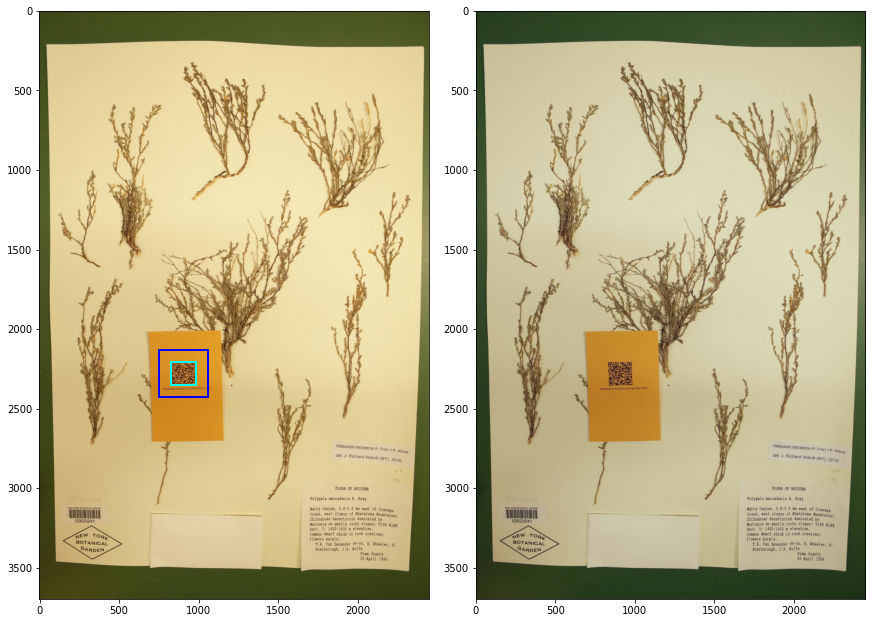

In [25]:
# interact(
#     show_images,
#     idx=(0, len(IN_PATHS) - 1),
#     figsize=([10, 12, 15, 20, 25]))
show_images(559, 12)